### Get started with KANs

Initialize KAN

In [38]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 3D inputs, 1D output, and 6 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[3,5,1], grid=5, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


Create dataset

The target function is

$$
    f(x_1, x_2, x_3) = x_1 + \mathrm{e}^{\sin(\pi x_2) + x_3^2}
$$

In [39]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: x[:,[0]] + torch.exp(torch.sin(torch.pi*x[:,[1]]) + x[:,[2]]**2)
dataset = create_dataset(f, n_var=3, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 3]), torch.Size([1000, 1]))

Plot KAN at initialization

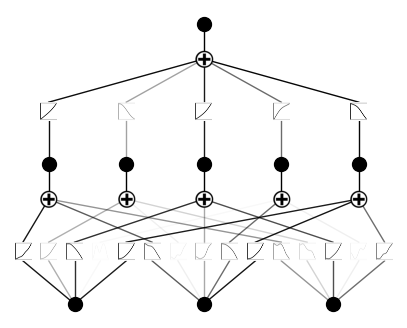

In [40]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

Train KAN with sparsity regularization

In [41]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.05e-02 | test_loss: 1.18e-02 | reg: 9.46e+00 | : 100%|█| 50/50 [00:09<00:00,  5.02it

saving model version 0.1


Plot trained KAN

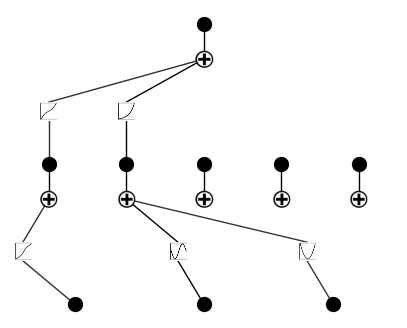

In [42]:
model.plot()

Prune KAN and replot

saving model version 0.2


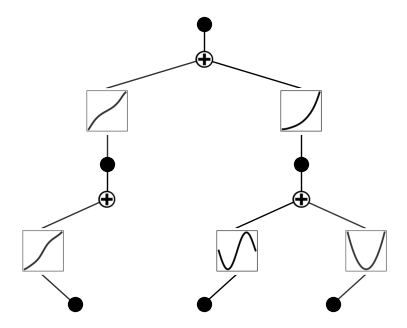

In [43]:
model = model.prune()
model.plot()

Continue training and replot

In [44]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 6.54e-03 | test_loss: 6.97e-03 | reg: 1.08e+01 | : 100%|█| 50/50 [00:05<00:00,  9.57it

saving model version 0.3


In [45]:
model = model.refine(10)

saving model version 0.4


In [46]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 3.55e-04 | test_loss: 4.47e-04 | reg: 1.08e+01 | : 100%|█| 50/50 [00:06<00:00,  7.24it

saving model version 0.5


Automatically or manually set activation functions to be symbolic

In [47]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.9879460488799233, c=1
fixing (0,0,1) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with sin, r2=0.9999999553613024, c=2
fixing (0,2,0) with 0
fixing (0,2,1) with x^2, r2=0.9999999898640183, c=2
fixing (1,0,0) with x, r2=0.9879398126532539, c=1
fixing (1,1,0) with exp, r2=0.9999999588629587, c=2
saving model version 0.6


Continue training till machine precision

In [48]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 7.92e-09 | test_loss: 8.00e-09 | reg: 0.00e+00 | : 100%|█| 50/50 [00:03<00:00, 16.65it

saving model version 0.7


Obtain the symbolic formula

In [49]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

1.0*x_1 + 1.0*exp(1.0*x_3**2 + 1.0*sin(3.1416*x_2))